In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv("final_dataset.csv")
df["Date"] = pd.to_datetime(df["Date"])

In [5]:
#drop source col
df.drop(columns=['source'], inplace=True)

In [6]:
#drop rows with no date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.dropna(subset=['Date'], inplace=True)

In [10]:
#interpolate missing prices and volume
cols = ['Close','High','Low','Open','Volume']
daily= df.groupby('Date')[cols].mean().reset_index()
daily['Date'] = pd.to_datetime(daily['Date'])
daily.set_index('Date', inplace=True)
daily[cols] = daily[cols].interpolate(method='time')
for col in cols:
    df[col] = df['Date'].map(daily[col])

In [11]:
#missing sentiments
missing_headlines = df['title'].isna()
df.loc[missing_headlines, ['negative','positive']] = 0
df.loc[missing_headlines, ['neutral']] = 1

In [12]:
#forwrad fill for interest rate and inflation
df[['interest_rate', 'inflation']] = df[['interest_rate', 'inflation']].fillna(method='ffill')

C:\Users\Dell\AppData\Local\Temp\ipykernel_14784\1984539751.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[['interest_rate', 'inflation']] = df[['interest_rate', 'inflation']].fillna(method='ffill')


In [13]:
#interpolate (time based) for usd index
usd_index_daily = df.groupby('Date')['usd_index'].mean() 
usd_index_daily = usd_index_daily.interpolate(method='time')
df['usd_index'] = df['Date'].map(usd_index_daily)

In [14]:
#handle missing headlines
df['title'] = df['title'].fillna('no headline')

In [15]:
#renaming
df.rename(columns={'Date': 'date'}, inplace=True)
df.rename(columns={'Close': 'close'}, inplace=True)
df.rename(columns={'High': 'high'}, inplace=True)
df.rename(columns={'Low': 'low'}, inplace=True)
df.rename(columns={'Open': 'open'}, inplace=True)
df.rename(columns={'Volume': 'volume'}, inplace=True)
df.rename(columns={'title': 'headline'}, inplace=True)

In [16]:
#cleaned csv
df.to_csv('cleaned_dataset.csv', index=False)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23693 entries, 0 to 23692
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              23693 non-null  datetime64[ns]
 1   close             23693 non-null  float64       
 2   high              23693 non-null  float64       
 3   low               23693 non-null  float64       
 4   open              23693 non-null  float64       
 5   volume            23693 non-null  float64       
 6   headline          23693 non-null  object        
 7   negative          23693 non-null  float64       
 8   neutral           23693 non-null  float64       
 9   positive          23693 non-null  float64       
 10  interest_rate     23693 non-null  float64       
 11  inflation         23693 non-null  float64       
 12  usd_index         23693 non-null  float64       
 13  season            23693 non-null  object        
 14  year              23693 non

In [19]:
#one hot encoding season
df = pd.read_csv('cleaned_dataset.csv')

season_dummies = pd.get_dummies(df['season'], prefix='season')
df = pd.concat([df, season_dummies], axis=1)
df.drop(columns=['season'], inplace=True)
df.to_csv('cleaned_dataset.csv', index=False)

In [1]:
#lag and rolling feature
import pandas as pd
df = pd.read_csv("cleaned_dataset.csv")

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)
daily_close = df.groupby('date')['close'].mean().reset_index()

#Lag features
lags = [1, 3, 7, 14, 30]
for lag in lags:
    daily_close[f'Close_lag{lag}'] = daily_close['close'].shift(lag)

#Rolling features
windows = [7, 30]
for window in windows:
    daily_close[f'Close_roll_mean_{window}'] = daily_close['close'].shift(1).rolling(window).mean()

lag_roll_cols = [c for c in daily_close.columns if 'lag' in c or 'roll' in c]
df = df.merge(daily_close[['date'] + lag_roll_cols], on='date', how='left')

#removing first 30 dates coz of NaN
unique_dates = sorted(df['date'].unique())
first_30_dates = unique_dates[:30]
df = df[~df['date'].isin(first_30_dates)]

In [2]:
#unscaled dataset
df.to_csv("dataset_unscaled.csv", index=False)

In [56]:
print(df.dtypes)

date                  datetime64[ns]
close                        float64
high                         float64
low                          float64
open                         float64
volume                       float64
headline                      object
negative                     float64
neutral                      float64
positive                     float64
interest_rate                float64
inflation                    float64
usd_index                    float64
year                           int64
month                          int64
day                            int64
day_of_week                    int64
week_of_year                   int64
quarter                        int64
is_weekend                     int64
days_since_start               int64
month_sin                    float64
month_cos                    float64
dayofweek_sin                float64
dayofweek_cos                float64
season_Autumn                   bool
season_Spring                   bool
s

In [6]:
#scaling
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = df.copy()  

do_not_scale = [
    "date",        
    "headline",    
    "season_Autumn",
    "season_Spring",
    "season_Summer",
    "season_Winter"
]

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
# remove boolean season columns
numeric_cols = [col for col in numeric_cols if col not in do_not_scale]

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])

df_scaled.to_csv("dataset_scaled.csv", index=False)

print("Scaling done")

Scaling done


        date        close      high       low      open    volume  \
0 2019-04-12  1290.599976 -1.489552 -1.479883 -1.486482 -0.144043   
1 2019-04-12  1290.599976 -1.489552 -1.479883 -1.486482 -0.144043   
2 2019-04-12  1290.599976 -1.489552 -1.479883 -1.486482 -0.144043   
3 2019-04-12  1290.599976 -1.489552 -1.479883 -1.486482 -0.144043   
4 2019-04-12  1290.599976 -1.489552 -1.479883 -1.486482 -0.144043   

                                            headline  negative   neutral  \
0  One Dead In Microlight crash at Royal Birkdale... -0.450219  0.869036   
1  Germany: Muslim Woman on trial for torturing S... -0.410785  1.024485   
2  Jussie Smollett sued over Chicago police overt... -0.484256  1.475900   
3  Authorities say deputys son behind fires at b... -0.331487  1.054751   
4  White House proposed releasing immigrant detai... -0.467768  1.317333   

   positive  ...  season_Spring  season_Summer  season_Winter  Close_lag1  \
0 -0.677299  ...           True          False     

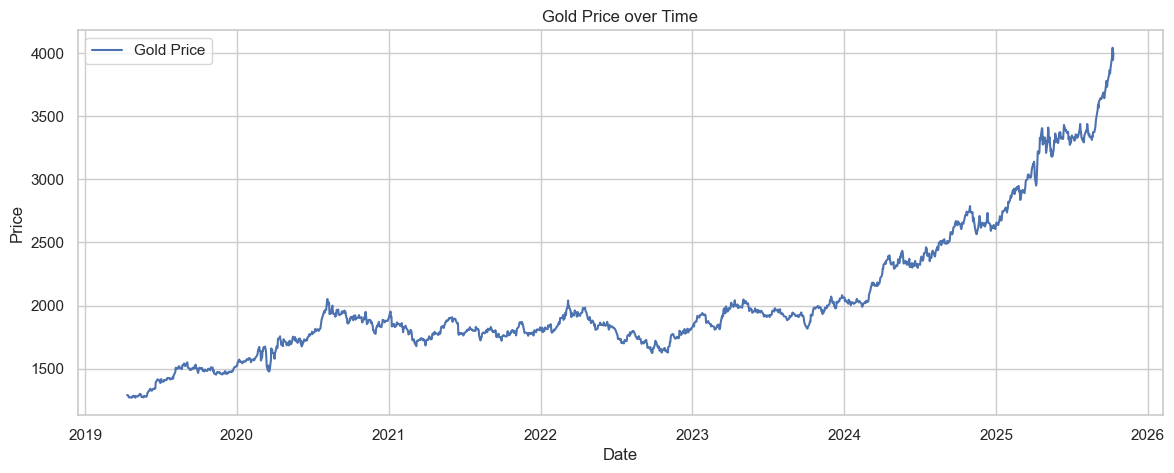

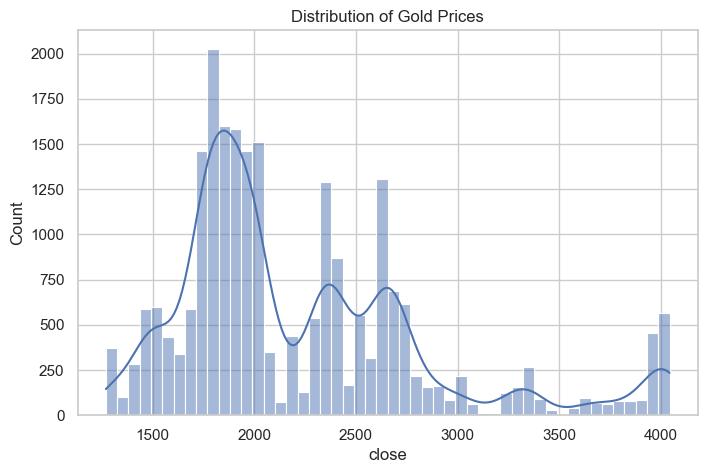

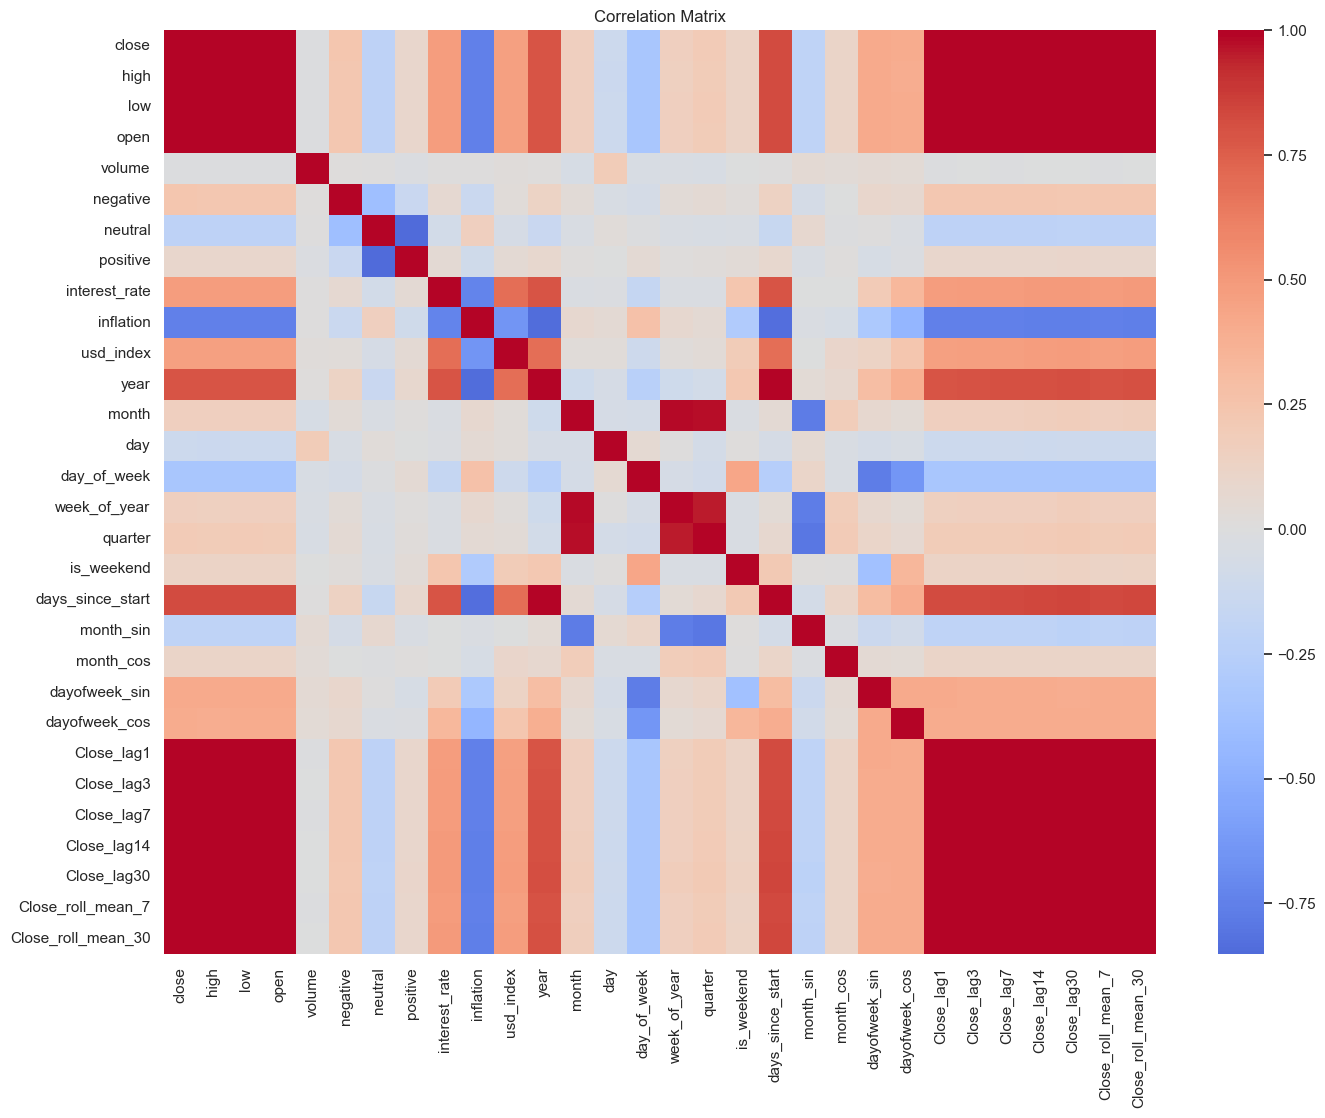

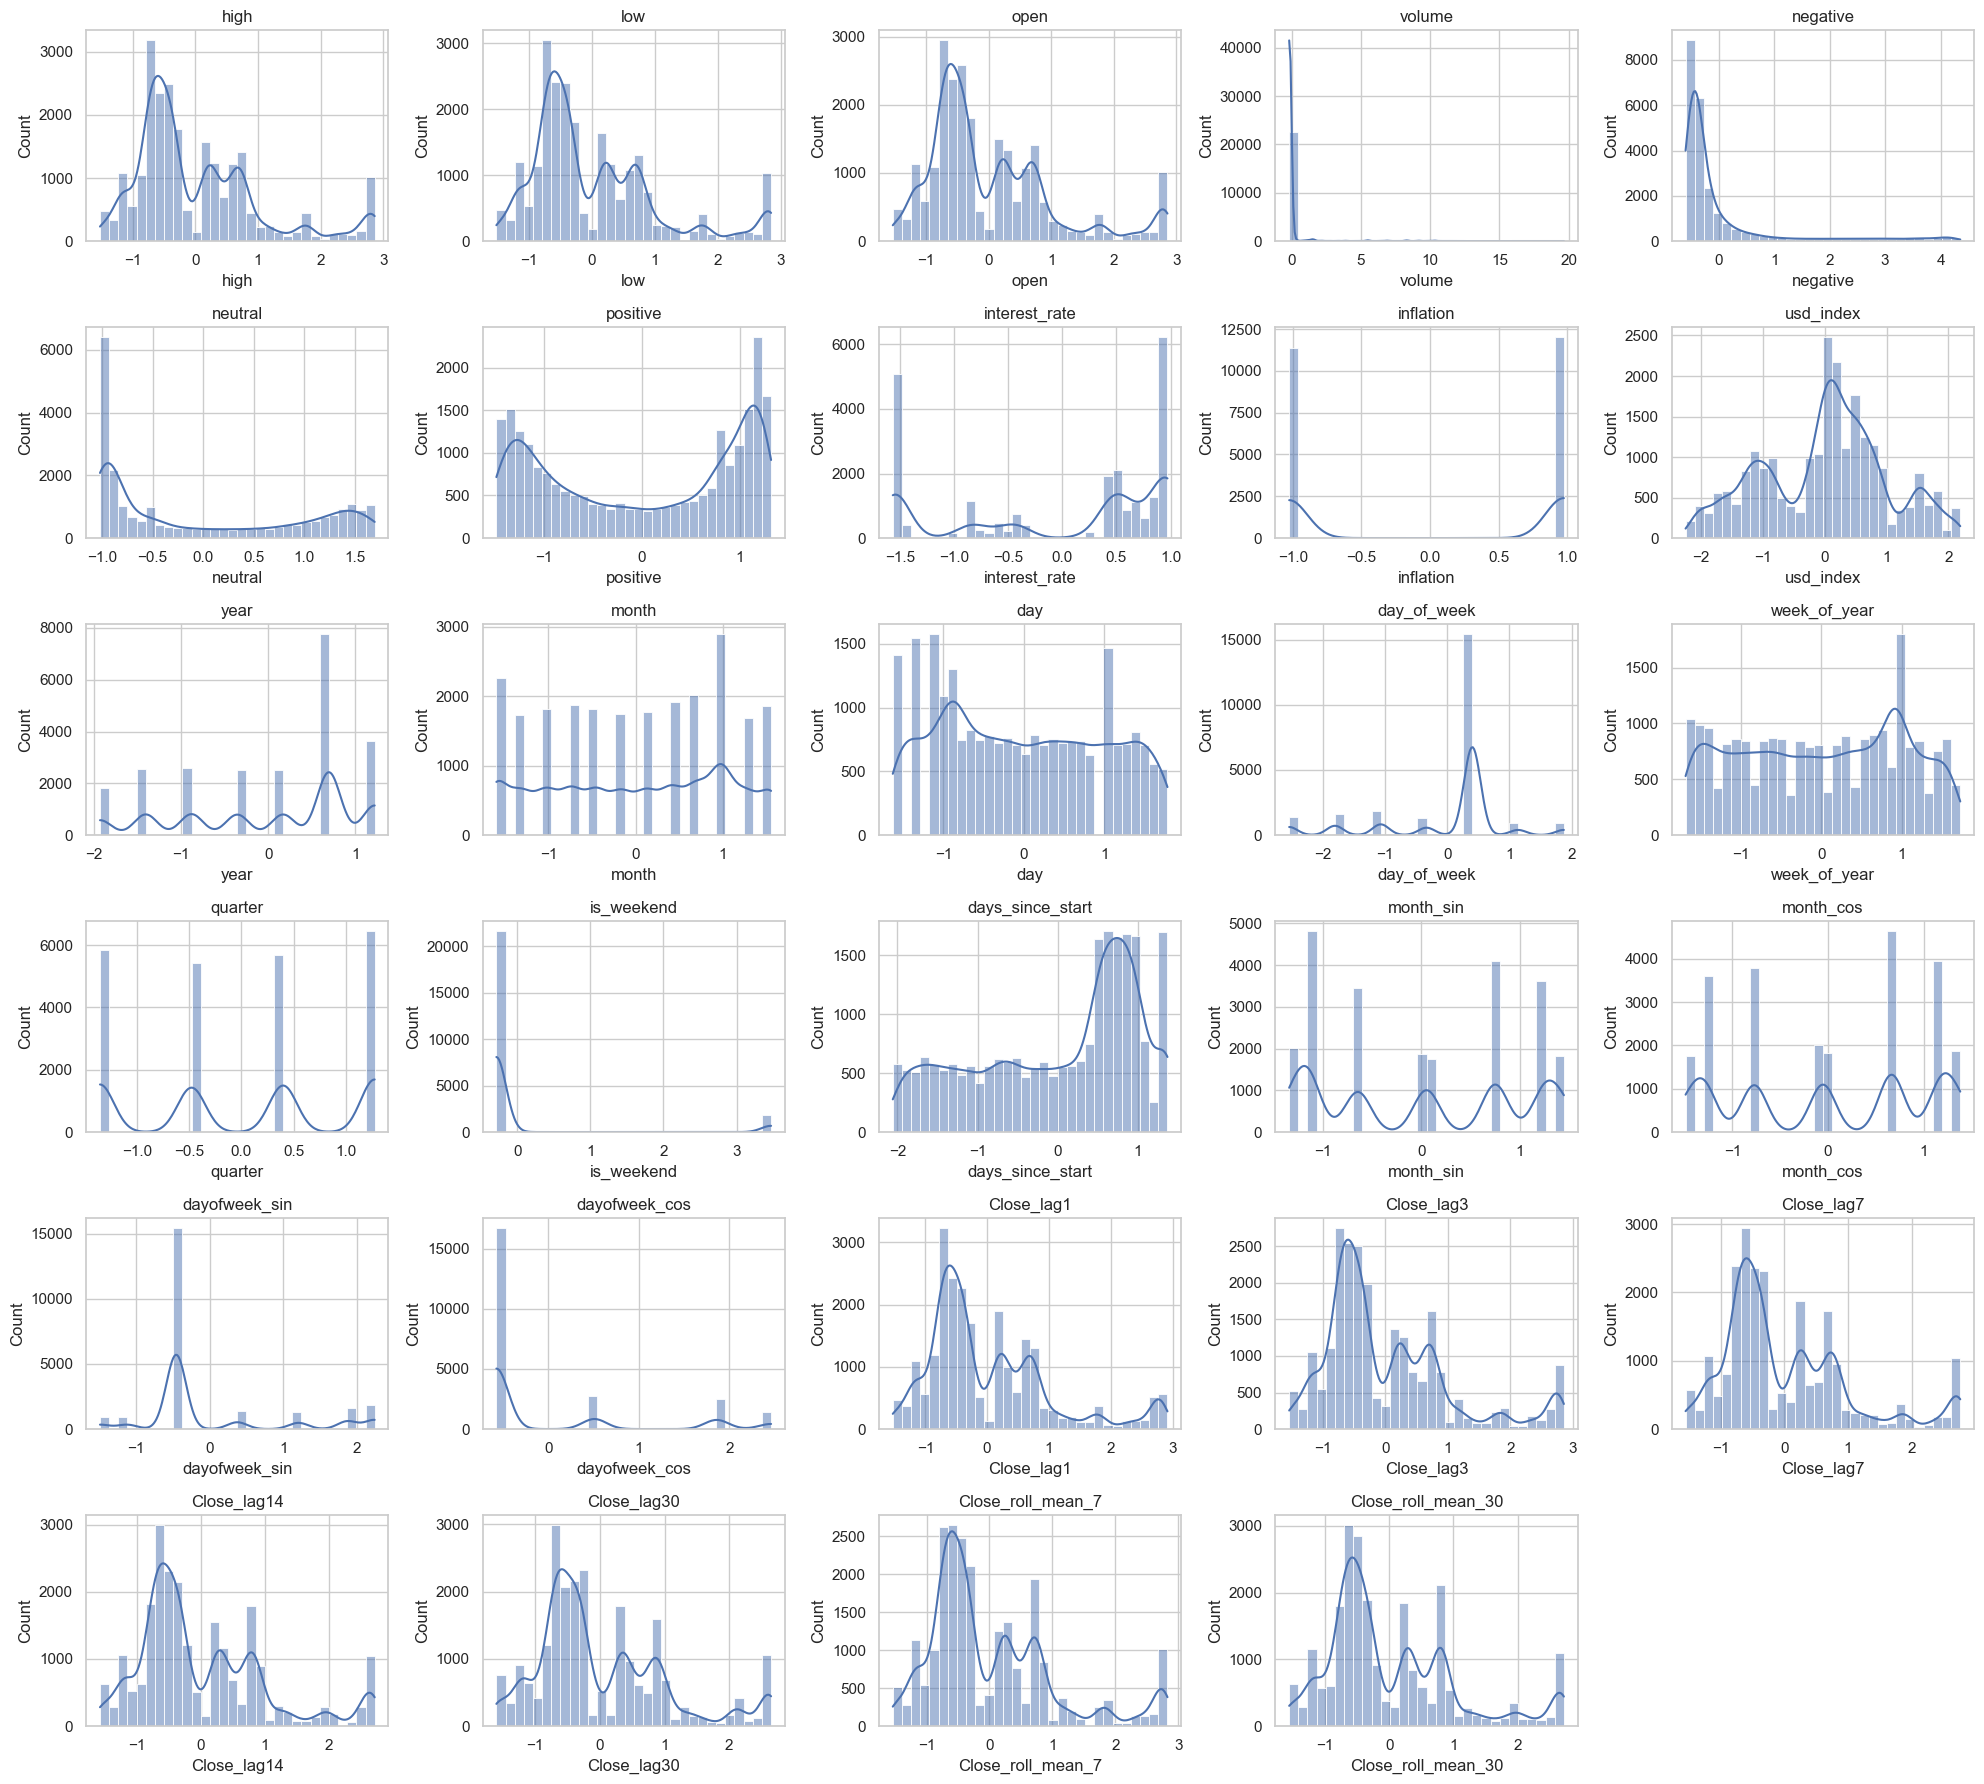

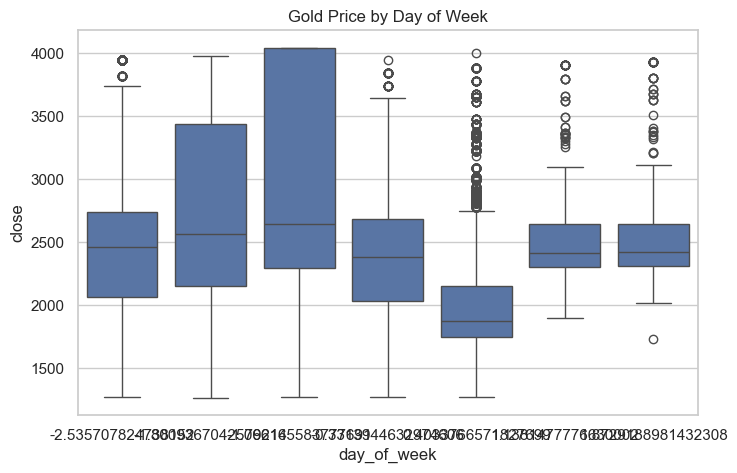

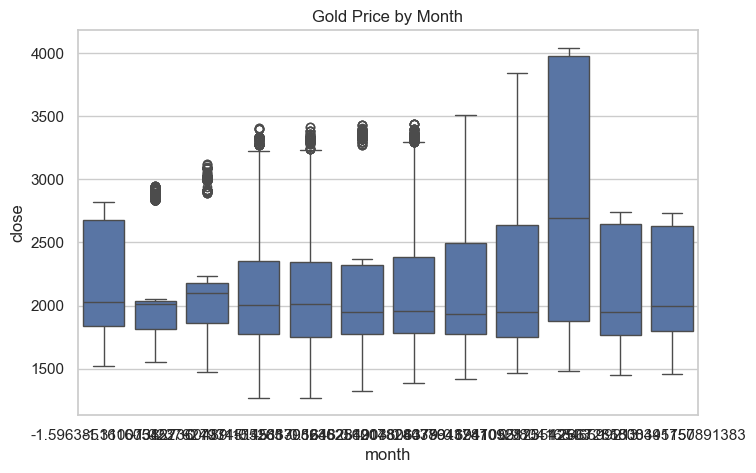

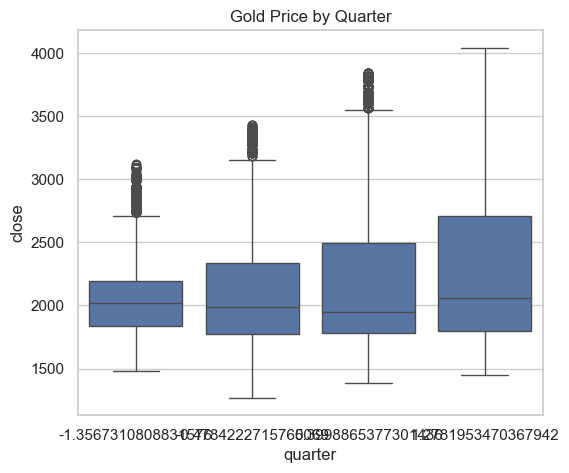

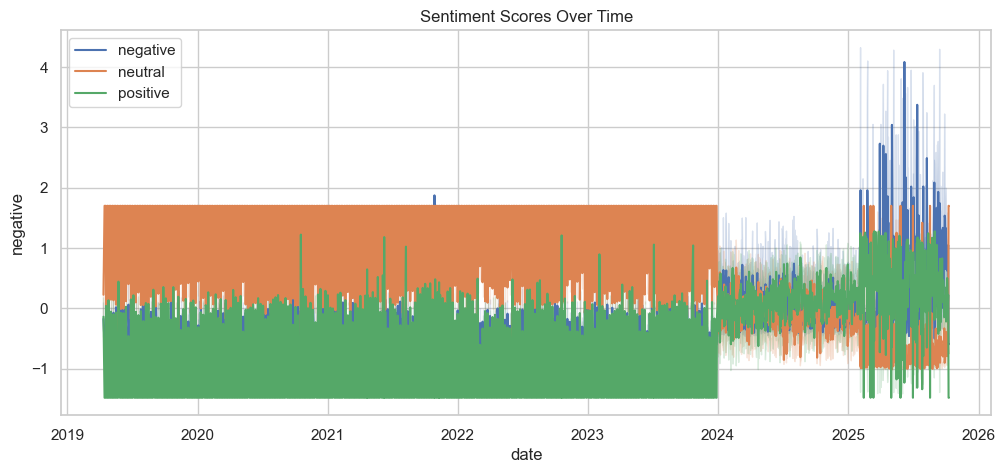

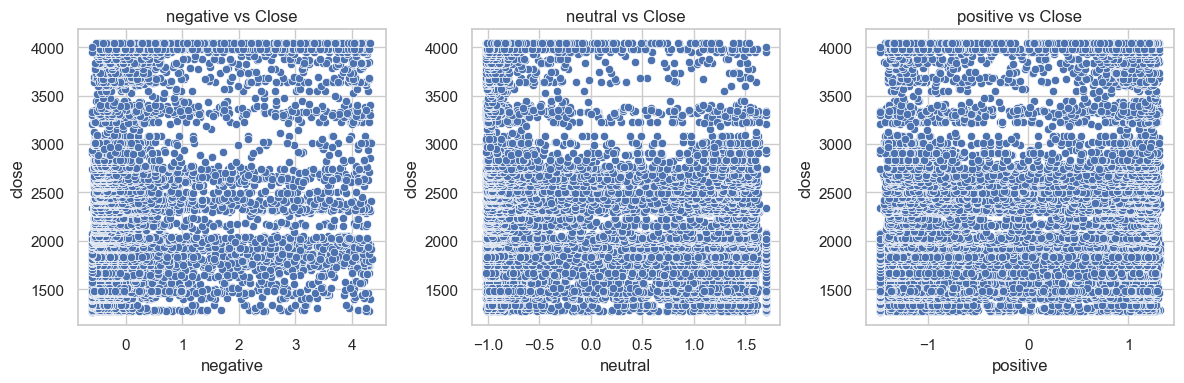

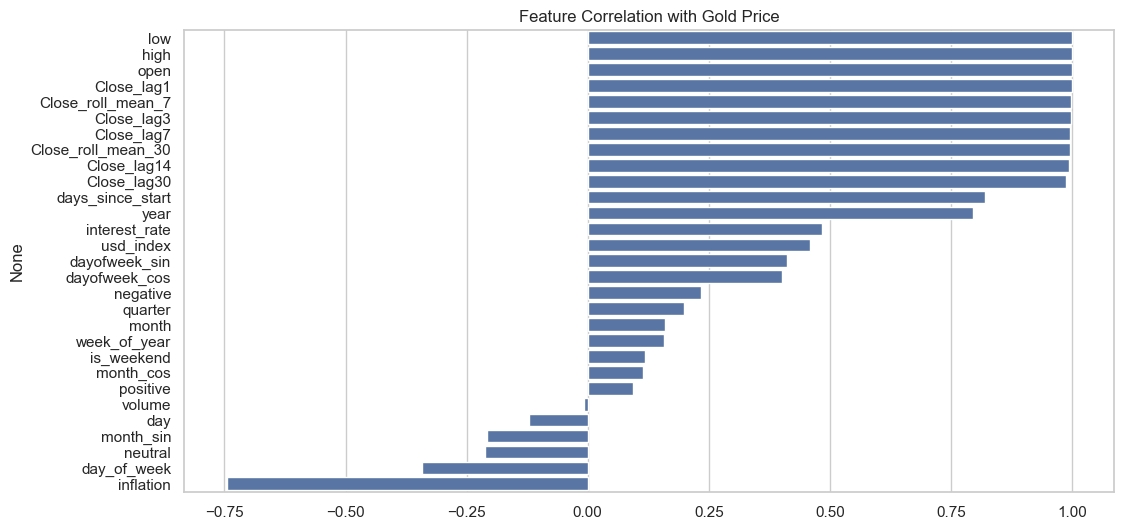

In [4]:
#EDA
import matplotlib.pyplot as plt
import seaborn as sns
import math

sns.set(style="whitegrid")
%matplotlib inline
df = pd.read_csv("dataset_scaled.csv")  # scaled dataset for EDA
df['date'] = pd.to_datetime(df['date'])
# First rows
print(df.head())
# Info about columns
print(df.info())
# Check for any missing values
print(df.isna().sum())
# Summary statistics
print(df.describe())

plt.figure(figsize=(14,5))
plt.plot(df['date'], df['close'], label='Gold Price')
plt.title("Gold Price over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Histogram
plt.figure(figsize=(8,5))
sns.histplot(df['close'], bins=50, kde=True)
plt.title("Distribution of Gold Prices")
plt.show()

# Correlation matrix
numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr = numeric_df.corr()

plt.figure(figsize=(16,12))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

# Histograms of numeric features
numeric_cols = numeric_df.columns.tolist()
numeric_cols.remove('close')  # skip target

num_cols = len(numeric_cols)
cols = 5  
rows = math.ceil(num_cols / cols)

plt.figure(figsize=(cols*4, rows*3))
for i, col in enumerate(numeric_cols):
    plt.subplot(rows, cols, i+1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()


#Boxplots for day, month, quarter
plt.figure(figsize=(8,5))
sns.boxplot(x='day_of_week', y='close', data=df)
plt.title("Gold Price by Day of Week")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='month', y='close', data=df)
plt.title("Gold Price by Month")
plt.show()

plt.figure(figsize=(6,5))
sns.boxplot(x='quarter', y='close', data=df)
plt.title("Gold Price by Quarter")
plt.show()

#Sentiment plots
sent_cols = ['negative', 'neutral', 'positive']

# Sentiment over time
plt.figure(figsize=(12,5))
for col in sent_cols:
    sns.lineplot(x=df['date'], y=df[col], label=col)
plt.title("Sentiment Scores Over Time")
plt.show()

# Scatter sentiment vs Close
plt.figure(figsize=(12,4))
for i, col in enumerate(sent_cols):
    plt.subplot(1,3,i+1)
    sns.scatterplot(x=df[col], y=df['close'])
    plt.title(f"{col} vs Close")
plt.tight_layout()
plt.show()

#Correlation-based feature importance
feature_corr = numeric_df.corr()['close'].drop('close').sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=feature_corr.values, y=feature_corr.index)
plt.title("Feature Correlation with Gold Price")
plt.show()

In [4]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

# Load dataset
df = pd.read_csv("dataset_scaled.csv")

# --- Create next-day targets ---
df["low_next"] = df["low"].shift(-1)
df["high_next"] = df["high"].shift(-1)
df["close_next"] = df["close"].shift(-1)

# Drop last row (because of shift)
df = df.iloc[:-1]

# Feature selection: all numeric except targets
features = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
for col in ["low_next", "high_next", "close_next", "close"]:
    if col in features:
        features.remove(col)

X = df[features]
y_low = df["low_next"]
y_high = df["high_next"]
y_close = df["close_next"]

# ---- TRAIN-TEST SPLIT (time series) ----
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_low_train, y_low_test = y_low[:train_size], y_low[train_size:]
y_high_train, y_high_test = y_high[:train_size], y_high[train_size:]
y_close_test = y_close[train_size:]

# ---- Train KNN models ----
knn_low = KNeighborsRegressor(n_neighbors=5, weights="distance")
knn_high = KNeighborsRegressor(n_neighbors=5, weights="distance")

knn_low.fit(X_train, y_low_train)
knn_high.fit(X_train, y_high_train)

# ---- Predictions ----
pred_low = knn_low.predict(X_test)
pred_high = knn_high.predict(X_test)

# ---- Range accuracy ----
correct = (
    (y_close_test >= pred_low) &
    (y_close_test <= pred_high)
).sum()

total = len(y_close_test)
range_accuracy = correct / total

print("\n===== KNN RANGE MODEL METRICS =====")
print(f"Low R2:  {r2_score(y_low_test, pred_low):.4f}")
print(f"High R2: {r2_score(y_high_test, pred_high):.4f}")
print(f"Range Accuracy: {range_accuracy * 100:.2f}%")

# ---- Show 10 sample predictions ----
sample = pd.DataFrame({
    "Pred Low": pred_low[:10],
    "Actual Close": y_close_test[:10].values,
    "Pred High": pred_high[:10]
})

print("\n===== SAMPLE PREDICTIONS (10 rows) =====")
print(sample)



===== KNN RANGE MODEL METRICS =====
Low R2:  -1.2167
High R2: -1.2103
Range Accuracy: 0.00%

===== SAMPLE PREDICTIONS (10 rows) =====
   Pred Low  Actual Close  Pred High
0  0.594160   2565.699951   0.550487
1  0.566575   2565.699951   0.520587
2  0.566575   2565.699951   0.520587
3  0.587930   2565.699951   0.543734
4  0.628086   2565.699951   0.585940
5  0.566575   2565.699951   0.520587
6  0.566575   2565.699951   0.520587
7  0.566575   2565.699951   0.520587
8  0.566575   2565.699951   0.520587
9  0.566575   2565.699951   0.520587
